In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime
import mlccd_models

# deactivate GPU on ragnarok
tf.config.set_visible_devices([], "GPU")

2024-09-04 00:07:31.361215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 00:07:31.377337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 00:07:31.382238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 00:07:31.394206: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 00:07:32.090545: W tensorflow/compiler/tf2

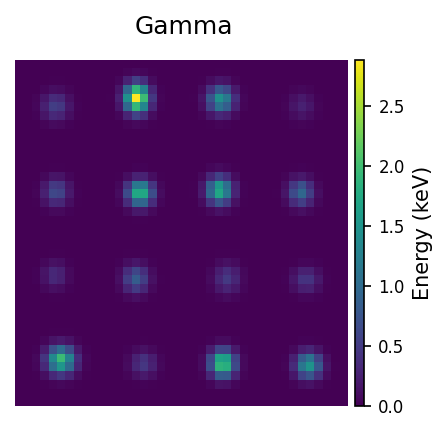

In [2]:
# Load the training and test data
data_tritium = mlccd_models.CCDData(
    # "/home/erofors/data/CCD_data/diffused_H3_5000000.h5"
    "/home/erofors/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output/diffused_H3_5000000.h5"
)
data_gamma = mlccd_models.CCDData(
    # "/home/erofors/data/CCD_data/diffused_gamma_50000000.h5"
    "/home/erofors/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output/diffused_gamma_1000000000.h5"
)
data_gamma.plot(title="Gamma")
data_tritium.plot(title="Tritium")

In [3]:
data_gamma.tracks_metadata

index  primaryID   x_first_um   y_first_um  z_first_um  primaryKind  \
0           0         40   381.610898  1617.830995    7.687477           22   
1           1       3644  4221.547527 -2419.507498    4.802197           22   
2           2       4052   100.522488   190.360312    6.655663           22   
3           3       4118   -24.116312    22.895336    6.112460           22   
4           4       4500   -10.591311   -61.098039    7.326213           22   
...       ...        ...          ...          ...         ...          ...   
839784  10521  999988908  -630.938271   108.963848    8.203474           22   
839785  10522  999992430     3.110864    -0.659264    2.036102           22   
839786  10523  999993036     3.120709   -45.226269    7.602282           22   
839787  10524  999994696   234.801587   603.346740    9.374516           22   
839788  10525  999996226    -7.925376     9.214733    6.322833           22   

        energyPrimaryKeV  preStepEnergy stepKindsUnique  \
0                  100.0       0.088490           b'11'   
1                  100.0      19.928726           b'11'   
2                  100.0      10.609501           b'11'   
3                  100.0       0.094940           b'11'   
4                  100.0       0.088490           b'11'   
...                  ...            ...             ...   
839784             100.0       0.088490           b'11'   
839785             100.0       0.087830           b'11'   
839786             100.0       0.088490           b'11'   
839787             100.0       0.088520           b'11'   
839788             100.0       1.307235           b'11'   

        energyDepositionSumKeV  
0                     4.106526  
1                    19.928726  
2                    10.609501  
3                     1.918298  
4                     4.765368  
...                        ...  
839784                5.356679  
839785                9.718465  
839786                7.541042  
839787                4.077529  
839788                1.307235  

[839789 rows x 10 columns]

In [4]:
# Combine the two datasets
ccd_data = 0.5 * data_gamma + 0.2 * data_tritium
# Clip the data between thresholds and normalize to 0-1
ccd_data.normalize(threshold_low=0, threshold_high=20)
# Divide the data into training, test, and validation sets
ccd_data.divide_data(
    train_fraction=0.7, test_fraction=0.2, validation_fraction=0.1
)

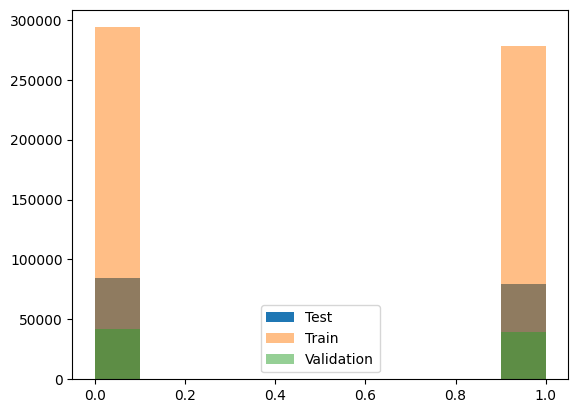

In [5]:
plt.hist(ccd_data.y_test, label="Test")
plt.hist(ccd_data.y_train, label="Train", alpha=0.5)
plt.hist(ccd_data.y_validation, label="Validation", alpha=0.5)
plt.legend()

In [8]:
gamma = 2
loss_function = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=gamma, from_logits=False, apply_class_balancing=True
)
# loss_function = 'binary_crossentropy'
config = {
    "model_name": f'cnn_{datetime.datetime.now().strftime("%Y%m%d_%H%M")}',
    "learning_rate": 0.001,
    "architecture": "MLP",
    "dataset": ccd_data.file_path,
    "epochs": 25,
    "batch_size": 256 * 4,
    "loss_function": loss_function,
    "threshold_high": ccd_data.threshold_high,
    "threshold_low": ccd_data.threshold_low,
    "data_filename": ccd_data.file_path,
}

In [6]:
def MLPModel(input_shape, hidden_units, dropout_rate=0.2):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hidden_units[0], activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(hidden_units[1], activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Example usage
input_shape = (10, 10, 1)  # 10x10 grayscale images
hidden_units = [64, 32]    # Two hidden layers with 64 and 32 units respectively

model = MLPModel(input_shape, hidden_units)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/home/erofors/miniconda3/envs/mlccd/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emirof (anp). Use `wandb login --relogin` to force relogin


Epoch 1/25


I0000 00:00:1725433728.294873 1575342 service.cc:146] XLA service 0x7f636028a170 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725433728.294939 1575342 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-09-04 00:08:48.319201: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 66/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5115 - loss: 0.6874

I0000 00:00:1725433728.799498 1575342 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


559/559 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6012 - loss: 0.6433

wandb: ERROR Unable to log learning rate.


5111/5111 ━━━━━━━━━━━━━━━━━━━━ 3s 538us/step
559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6012 - loss: 0.6433 - val_accuracy: 0.6500 - val_loss: 0.6016
Epoch 2/25
5111/5111 ━━━━━━━━━━━━━━━━━━━━ 3s 522us/step
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6494 - loss: 0.6035 - val_accuracy: 0.6660 - val_loss: 0.5905
Epoch 3/25
5111/5111 ━━━━━━━━━━━━━━━━━━━━ 3s 533us/step
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6649 - loss: 0.5926 - val_accuracy: 0.6789 - val_loss: 0.5827
Epoch 4/25
5111/5111 ━━━━━━━━━━━━━━━━━━━━ 3s 541us/step
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6791 - loss: 0.5836 - val_accuracy: 0.6927 - val_loss: 0.5701
Epoch 5/25
5111/5111 ━━━━━━━━━━━━━━━━━━━━ 3s 535us/step
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6910 - loss: 0.5741 - val_accuracy: 0.6984 - val_loss: 0.5656
Epoch 6/25
5111/5111 ━━━━━━━━━━━━━━━━━━━━ 3s 624us/step
559/559 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6963 - loss: 0.5701 - val_accurac

wandb: WARNING wandb uses only 10000 data points to create the plots.


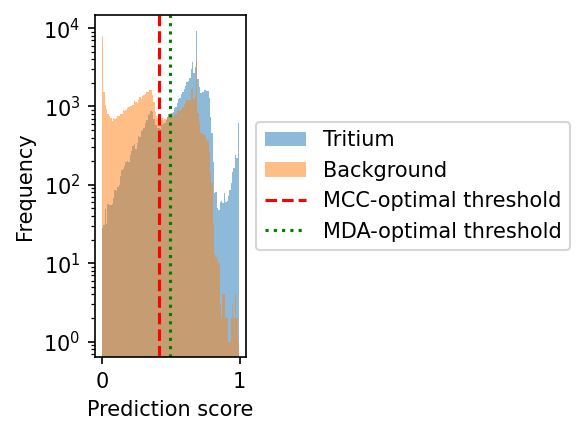

In [9]:
mlccd_models.train(model=model, config=config, ccd_data=ccd_data)

5111/5111 ━━━━━━━━━━━━━━━━━━━━ 3s 679us/step


(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Receiver Operating Characteristic'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

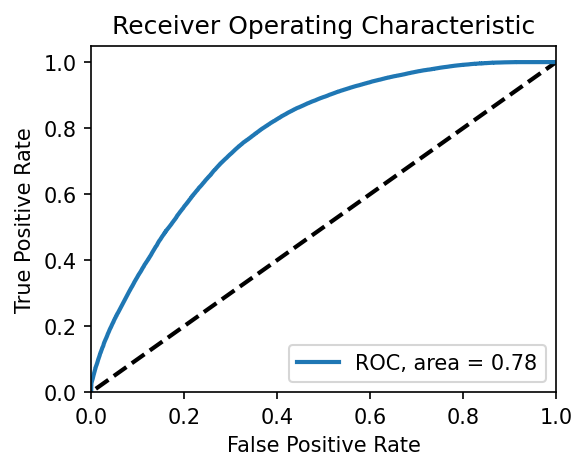

In [10]:
y_pred = model.predict(ccd_data.x_test)
mlccd_models.plot_roc_curve(ccd_data.y_test, y_pred)

In [11]:
max_mcc, mcc_threshold = (
    mlccd_models.scan_mcc(
        ccd_data.y_test, y_pred, plot=True
    )
)

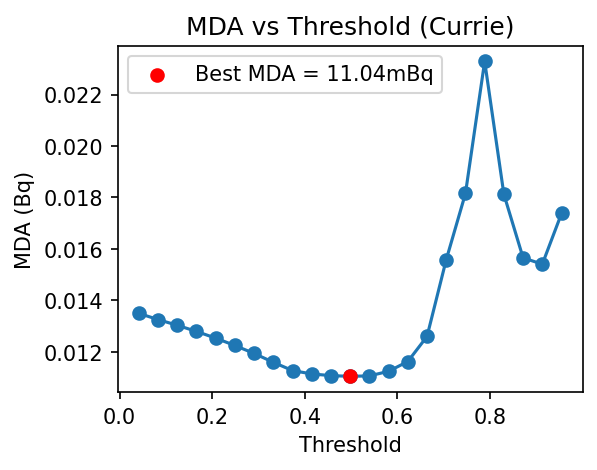

In [12]:
min_mda, mda_threshold = mlccd_models.scan_mda(ccd_data.y_test, y_pred, plot=True)

In [13]:

_ = mlccd_models.plot_confusion_matrix(
    ccd_data.y_test, y_pred, threshold=mcc_threshold
)

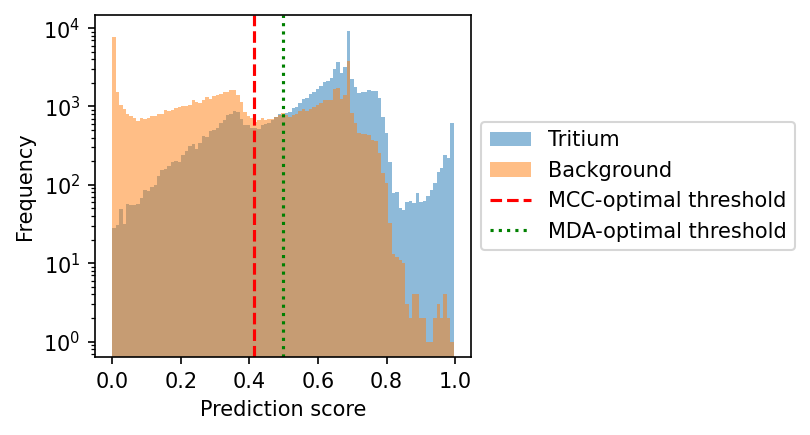

In [15]:
fig, ax  = mlccd_models.plot_scores(ccd_data.y_test, y_pred, threshold_mcc_optimal=mcc_threshold, threshold_mda_optimal=mda_threshold)